In [1]:
#library(precintcon)

In [1]:
library(Rlibeemd)

If you installed Rlibeemd from CRAN, consider installing again from GitHub if you wish to support for parallel computations: https://github.com/helske/Rlibeemd.


In [2]:
library(forecast)
library(ncdf4)
library(ggplot2)

#library(tseries)
#library(MASS)
library(fitdistrplus)
library(zoo)

Loading required package: MASS
Loading required package: survival
Loading required package: npsurv
Loading required package: lsei

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [2]:
spiParameters<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    
    means = mean(x.n)
    log.means = log(means)
    mean.logs = mean(log(x.n))
    U = log.means - mean.logs
    alpha = (1 + sqrt(1 + 4 * U / 3)) / (4 * U)
    beta = means / alpha
    
    q = length(x.n[x.n == 0.0]) / length(x.n)
    #probabilities = pgamma(x.n, shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])
    #result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    returnList <- list("alpha" = alpha, "beta" = beta, "q" = q)
    return(returnList)
}


spiGeneratorParam<-function(x,params,n_months){
    x.n = rollapply(x, n_months, sum)
    G = pgamma(x.n, shape = params$alpha, rate = params$beta)
    #q = length(x[x == 0.0]) / length(x)
    probabilities = params$q + (1 - params$q) * G
    result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(result)
}

spiGenerator<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    
    means = mean(x.n)
    log.means = log(means)
    mean.logs = mean(log(x.n))
    U = log.means - mean.logs
    alpha = (1 + sqrt(1 + 4 * U / 3)) / (4 * U)
    beta = means / alpha
    
    G = pgamma(x.n, shape = alpha, rate = beta)
    q = length(x.n[x.n == 0.0]) / length(x.n)
    probabilities = q + (1 - q) * G
    result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(result)
}


spiParametersMle<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    i = x.n == 0.0
    fit.gamma <- fitdist(x.n[!i], distr = "gamma", method = "mle")
    q = length(x.n[i]) / length(x.n)
    #probabilities = pgamma(x.n, shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])
    #result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    returnList <- list("fit" = fit.gamma, "q" = q)
    return(returnList)
}

spiGeneratorMle<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    i = x.n == 0.0
    
    fit.gamma <- fitdist(x.n[!i], distr = "gamma", method = "mle")
    G = pgamma(x.n[!i], shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])
    
    q = length(x.n[i]) / length(x.n)
    probabilities = array(0.0, length(x.n))
    probabilities[i] = q
    probabilities[!i] = q + (1 - q) * G
    result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(result)
}

spiGeneratorParamMle<-function(x,params,n_months){
    x.n = rollapply(x, n_months, sum)
    i = x.n == 0.0
    
    G = pgamma(x.n[!i], shape = params$fit$estimate[1], rate = params$fit$estimate[2])
    #q = length(x[x == 0.0]) / length(x)
    probabilities = array(0.0, length(x.n))
    probabilities[i] = params$q
    probabilities[!i] = params$q + (1 - params$q) * G
    result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    return(result)
}

In [3]:
year_to_index<-function(year, month = 1, start_year = 1946, f = 12){
    return((year - start_year) * f + month)
}

In [4]:
phase_average<-function(x, freq)
{    
  N = length(x)
  result = numeric(N)
  averages = numeric(freq)
  stds = numeric(freq)    
  for (j in 1:freq){
        Idx = seq(j,N,12)
        averages[j] = mean(x[Idx])
        stds[j] = sd(x[Idx])
      if(stds[j] == 0){
          result[Idx] =  0
      }else{
        result[Idx] = (x[Idx] - averages[j])/stds[j]
          }
      
      }
    returnList <- list("result" = result, "averages" = averages, "stds" = stds)
    return(returnList)  
}

In [5]:
inv_phase_average<-function(x, freq, avg, std)
{    
  N = length(x)
  result = numeric(N)  
  for (j in 1:freq){
        Idx = seq(j,N,freq)
        result[Idx] = x[Idx]* std[j] + avg[j]      
      }
    return(result)  
}

In [121]:
nc <- nc_open("spi3_6_12_1deg_cru_ts_3_21_1949_2012.nc")

lat <- ncvar_get(nc,"lat",verbose=F)
lon <- ncvar_get(nc,"lon",verbose=F)

time <- ncvar_get(nc,"time",verbose=F)

In [3]:
attributes(nc$var)

$names
[1] "spi3"  "spi6"  "spi12" "date"

In [122]:
spi12 <- ncvar_get(nc, attributes(nc$var)$names[3])

In [5]:
lat[104]

lon[219]

[1] 13.5

[1] 38.5

In [123]:
spi12[200,100,dim(spi12)[3]]

[1] 1.182925

In [26]:
#spi12[200,100,]

In [124]:
x<-spi12[200,100,]

In [12]:
x <- x[!is.na(x)]

In [6]:
load("data.RData")
load("lat.RData")
load("lon.RData")

In [278]:
#x<-x[22,8,2:dim(x)[3]]  #cluster==2
#x<-x[28,7,3:dim(x)[3]]   #cluster==0
#x<-df_cluster[["X1"]]
#x.ts<-ts(x, start = c(194, 12), freq=f)

#x <- fuzzify(x)

n=20
# Set forecasting window length (in years)
m=1
# Set start year
start = 1946
start_month = 1
origin = 1985
# Set annual sampling rate
f = 12
h = m*f
n_months = 3
#h.spi = h - n_months + 1
index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start <- index
train_end <- train_start+n*f-1

test_start <- train_end + 1
test_end <- test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]
#reg.train<-df[train_start:train_end,]
#reg.test<-df[test_start:test_end,]

x.ts = ts(x, start=c(origin, start_month), freq=f)

x.train <- ts(x.train, start = c(origin, start_month), freq=f)
#reg.train <- ts(reg.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, start_month), freq=f)
#reg.test <- ts(reg.test, start = c(origin+n, 1), freq=f)

lambda <- BoxCox.lambda(x.train)

In [279]:
x.train.spi = spiGeneratorMle(as.numeric(x.train), n_months)
params = spiParametersMle(as.numeric(x.train), n_months)
x.test.spi = spiGeneratorParamMle(as.numeric(c(x.train[length(x.train) - ((n_months-2):0)], x.test)),params, n_months)

In [280]:
x.train.spi = ts(x.train.spi, start = c(origin, start_month + n_months -1), freq=f)
x.test.spi = ts(x.test.spi, start = c(origin+n, start_month), freq=f)

In [302]:
year_to_index(1971)

[1] 301

In [303]:
year_to_index(2000,12)

[1] 660

In [304]:
load("data.RData")
load("lat.RData")
load("lon.RData")

n_train = 20
# Set forecasting window length (in years)
n_test = 1
# Set start year
start_year = 1946
# Set annual sampling rate
f = 12
h = n_test * f

calibration_start = 1971
calibration_end = 2000

skill <- list()

length.lon = dim(data)[1]
length.lat = dim(data)[2]
L = dim(data)[3]

end_year = start_year + ((L -(L %% f))/f)

In [335]:
start_year = 1981
origin = 1946

In [307]:
n_train+n_test

[1] 21

In [338]:
(end_year-(n_train+n_test))-start_year+1

[1] 15

In [8]:
load("data.RData")
load("lat.RData")
load("lon.RData")

In [11]:
x<-data[4,11,] 

In [12]:
load("data.RData")
load("lat.RData")
load("lon.RData")

n_train = 20
# Set forecasting window length (in years)
n_test = 1
# Set start year
start_year = 1981
start_month = 1
origin = 1946
# Set annual sampling rate
f = 12
h = n_test * f
n_months = 3

calibration_start = 1971
calibration_end = 2000

skill <- list()

length.lon = dim(data)[1]
length.lat = dim(data)[2]
L = dim(data)[3]

end_year = origin + ((L -(L %% f))/f)

df.A<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric, as.numeric, as.numeric, as.numeric )
names(df.A)<-c("i","j","lon","lat","RMSE","MAE","meanErrorRatio")

df.E<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric, as.numeric, as.numeric, as.numeric)
names(df.E)<-c("i","j","lon","lat","RMSE","MAE","meanErrorRatio")

#for(j in c(2:L)){


     #x <- data[i,j,]
      #x <- sapply(x, fuzzify)
      
      

      RMSE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      MAE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      errorRatio.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)

      RMSE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      MAE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      errorRatio.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)

      x.ts <- x[1:length(x)-1]
      N = length(x.ts)
        
      calibration = x[year_to_index(calibration_start):year_to_index(calibration_end)]   
      params = spiParametersMle(calibration, n_months)
        
      z_start = start_year - (origin - 1)

      for(z in seq(z_start,(N/f - z_start) - n_train - n_test + 1)){

        train_start = (z - 1)*f + 1
        train_end = train_start + n_train*f - 1

        test_start = train_end + 1
        test_end = test_start + n_test*f - 1

        x.train <- x[train_start:train_end]
        x.test <- x[test_start:test_end]
          
          
        x.train.spi = spiGeneratorParamMle(x.train, params, n_months)
        x.test.spi = spiGeneratorParamMle(c(x.train[length(x.train) - ((n_months-2):0)], x.test),params, n_months)

        x.train.spi = ts(x.train.spi, start = c(start_year + z, start_month + n_months -1), freq=f)
        x.test.spi = ts(x.test.spi, start = c(start_year+z+n_train, start_month), freq=f)
          
       
        A = try(forecast(auto.arima(x.train.spi, biasadj = TRUE),h=h, biasadj = TRUE)$mean)
        if(is.numeric(A)){
            error.A = accuracy(A, x.test.spi)
            RMSE.A[z - z_start] = as.numeric(error.A[1,2])
            MAE.A[z- z_start] = as.numeric(error.A[1,3])
            errorRatio.A[z- z_start] = RMSE.A[z- z_start]/mean(x.test)
        }else{
            print(i)
            print(j)

            RMSE.A[z - z_start] = NA
            MAE.A[z- z_start] = NA
            errorRatio.A[z- z_start] = NA

      }

          
          
        #pa = phase_average(x.train, f)
        #x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

    #APA = forecast(auto.arima(x.train.t),h=h)$mean
  
          
        
        error.A = accuracy(A, x.test.spi)
   # error.E = accuracy(EBCZT, x.test)

    RMSE.A[z - z_start] = as.numeric(error.A[1,2])
    MAE.A[z- z_start] = as.numeric(error.A[1,3])
    errorRatio.A[z- z_start] = RMSE.A[z- z_start]/mean(x.test)


  #  RMSE.E[z] = as.numeric(error.E[1,2])
  #  MAE.E[z] = as.numeric(error.E[1,3])
  #  errorRatio.E[z] = RMSE.E[z]/mean(x.test)

  }

  # Now calculate average forecast errors
  meanRMSE.A = mean(RMSE.A, na.rm=TRUE)
 # meanRMSE.E = mean(RMSE.E, na.rm=TRUE)
  meanErrorRatio.A = mean(errorRatio.A)

  meanMAE.A = mean(MAE.A, na.rm=TRUE)


        
        

<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = data,     gr = gradient, ddistnam = ddistname, hessian = TRUE, method = meth,     lower = lower, upper = upper, ...): non-finite finite-difference value [2]>


ERROR: Error in fitdist(x.n[!i], distr = "gamma", method = "mle"): the function mle failed to estimate the parameters, 
                with the error code 100



In [35]:
r = try(fit.gamma <- fitdist(x.n[!i], distr = "gamma", method = "mle"))

<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = data,     gr = gradient, ddistnam = ddistname, hessian = TRUE, method = meth,     lower = lower, upper = upper, ...): non-finite finite-difference value [2]>


In [38]:
if(class(r) == 'try-error'){print("hello")}

[1] "hello"


In [ ]:
      r = try(forecast(auto.arima(mfs[,k], biasadj = TRUE),h=h, biasadj = TRUE)$mean)
      if(is.numeric(r)){
        result[k,] = r
      }else{
        print(i)
        print(j)
        print(k)
        result[k,] = rep(NA,h)
      }


In [16]:
x.n = rollapply(calibration, n_months, sum)

In [44]:
fit.gamma <- fitdist(x.n[!i], distr = "gamma", method = "mle")

<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = data,     gr = gradient, ddistnam = ddistname, hessian = TRUE, method = meth,     lower = lower, upper = upper, ...): non-finite finite-difference value [2]>


ERROR: Error in fitdist(x.n[!i], distr = "gamma", method = "mle"): the function mle failed to estimate the parameters, 
                with the error code 100



In [21]:
fit.gamma

Fitting of the distribution ' gamma ' by matching moments 
Parameters:
         estimate
shape 0.661954023
rate  0.003805303

In [42]:
spiParametersMle<-function(x, n_months){
    x.n = rollapply(x, n_months, sum)
    i = x.n == 0.0
    r = try(fit.gamma <- fitdist(x.n[!i], distr = "gamma", method = "mle"))
    if(class(r) == 'try-error'){
        fit.gamma <- fitdist(x.n[!i], distr = "gamma", method = "mme")
    }
    q = length(x.n[i]) / length(x.n)
    #probabilities = pgamma(x.n, shape = fit.gamma$estimate[1], rate = fit.gamma$estimate[2])
    #result = qnorm(probabilities, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
    returnList <- list("fit" = fit.gamma, "q" = q)
    return(returnList)
}

In [46]:
r = spiParametersMle(calibration, 3)

<simpleError in optim(par = vstart, fn = fnobj, fix.arg = fix.arg, obs = data,     gr = gradient, ddistnam = ddistname, hessian = TRUE, method = meth,     lower = lower, upper = upper, ...): non-finite finite-difference value [2]>


In [47]:
r

$fit
Fitting of the distribution ' gamma ' by matching moments 
Parameters:
         estimate
shape 0.661954023
rate  0.003805303

$q
[1] 0


In [13]:
load("data.RData")
load("lat.RData")
load("lon.RData")

n_train = 20
# Set forecasting window length (in years)
n_test = 1
# Set start year
start_year = 1981
start_month = 1
origin = 1946
# Set annual sampling rate
f = 12
h = n_test * f
n_months = 3

calibration_start = 1971
calibration_end = 2000

skill <- list()

length.lon = dim(data)[1]
length.lat = dim(data)[2]
L = dim(data)[3]

end_year = origin + ((L -(L %% f))/f)

df.A<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric, as.numeric, as.numeric, as.numeric )
names(df.A)<-c("i","j","lon","lat","RMSE","MAE","meanErrorRatio")

df.E<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric, as.numeric, as.numeric, as.numeric)
names(df.E)<-c("i","j","lon","lat","RMSE","MAE","meanErrorRatio")

#for(j in c(2:L)){

for(i in c(1:length.lon)){
  for(j in c(1:length.lat)){
    if(!is.na(data[i,j,L])){

     #x <- data[i,j,]
      #x <- sapply(x, fuzzify)
      
      

      RMSE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      MAE.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      errorRatio.A = array(0.0, (end_year-(n_train+n_test))-start_year+1)

      RMSE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      MAE.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)
      errorRatio.E = array(0.0, (end_year-(n_train+n_test))-start_year+1)

      x.ts <- x[1:length(x)-1]
      N = length(x.ts)
        
      calibration = x[year_to_index(calibration_start):year_to_index(calibration_end)]   
      params = spiParametersMle(calibration, n_months)
        
      z_start = start_year - (origin - 1)

      for(z in seq(z_start,(N/f - z_start) - n_train - n_test + 1)){

        train_start = (z - 1)*f + 1
        train_end = train_start + n_train*f - 1

        test_start = train_end + 1
        test_end = test_start + n_test*f - 1

        x.train <- x[train_start:train_end]
        x.test <- x[test_start:test_end]
          
          
        x.train.spi = spiGeneratorParamMle(x.train, params, n_months)
        x.test.spi = spiGeneratorParamMle(c(x.train[length(x.train) - ((n_months-2):0)], x.test),params, n_months)

        x.train.spi = ts(x.train.spi, start = c(start_year + z, start_month + n_months -1), freq=f)
        x.test.spi = ts(x.test.spi, start = c(start_year+z+n_train, start_month), freq=f)
          
        A = forecast(auto.arima(x.train.spi),h=h)$mean
          
          
        #pa = phase_average(x.train, f)
        #x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)

    #APA = forecast(auto.arima(x.train.t),h=h)$mean
  
          
        
        error.A = accuracy(A, x.test.spi)
   # error.E = accuracy(EBCZT, x.test)

    RMSE.A[z - z_start] = as.numeric(error.A[1,2])
    MAE.A[z- z_start] = as.numeric(error.A[1,3])
    errorRatio.A[z- z_start] = RMSE.A[z- z_start]/mean(x.test)


  #  RMSE.E[z] = as.numeric(error.E[1,2])
  #  MAE.E[z] = as.numeric(error.E[1,3])
  #  errorRatio.E[z] = RMSE.E[z]/mean(x.test)

  }

  # Now calculate average forecast errors
  meanRMSE.A = mean(RMSE.A, na.rm=TRUE)
 # meanRMSE.E = mean(RMSE.E, na.rm=TRUE)
  meanErrorRatio.A = mean(errorRatio.A)

  meanMAE.A = mean(MAE.A, na.rm=TRUE)

de.A<-data.frame(i,j,lon[i],lat[j],meanRMSE.A, meanMAE.A, meanErrorRatio.A)
 # de.E<-data.frame(i,j,lon[i],lat[j],meanRMSE.E, meanMAE.E, meanErrorRatio.E)

  names(de.A)<-c("i","j","lon","lat","meanRME", "meanMAE","meanErrorRatio")
 # names(de.E)<-c("i","j","lon","lat","meanRME", "meanMAE","meanErrorRatio")

  write.table(de.A, "./results/ACTemp.csv", sep = ",", col.names = !file.exists("./results/ACTemp.csv"), append = T)
 # write.table(de.E, "EBCZTTemp.csv", sep = ",", col.names = !file.exists("EBCZTTemp.csv"), append = T)

  df.A <- rbind(df.A,de.A)
 # df.E <- rbind(df.E,de.E)
    }
  }
}
write.csv(df.A, file = "./results/AC.csv")

        
        

Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check 

In [14]:
 meanRMSE.A

[1] 1.072589

In [407]:
N/f

[1] 70

In [405]:
N/f - n_train - n_test + 1

[1] 50

In [9]:
x.train.spi

             Jan         Feb         Mar         Apr         May         Jun
1995                         -0.66031041 -0.81863960 -0.38579986 -0.42126773
1996 -0.81863960  0.30902511  0.30902511  0.28708846 -0.38579986 -0.42126773
1997  0.38135084  0.40088810 -0.66031041 -0.81863960 -0.38579986 -0.42126773
1998 -0.81863960 -0.66031041 -0.66031041 -0.81863960 -0.38579986 -0.42126773
1999 -0.81863960 -0.66031041 -0.66031041 -0.81863960 -0.38579986 -0.42126773
2000 -0.81863960 -0.66031041 -0.66031041 -0.81863960 -0.38579986 -0.42126773
2001 -0.81863960 -0.66031041 -0.66031041 -0.81863960 -0.38579986 -0.42126773
2002 -0.81863960 -0.66031041 -0.66031041 -0.81863960  0.37140620  0.36133927
2003 -0.81863960 -0.66031041 -0.66031041 -0.81863960 -0.42126772 -0.45968285
2004 -0.81863960 -0.66031041 -0.66031041 -0.81863960 -0.38579986 -0.42126773
2005 -0.81863960 -0.66031041 -0.01202536 -0.04729061  0.08330453 -0.42126773
2006 -0.81863960 -0.66031041 -0.66031041 -0.81863960 -0.38579986 -0.42126773

In [10]:
x.test.spi

             Jan         Feb         Mar         Apr         May         Jun
2015  0.93837859  0.94957373  0.94957373 -0.81863960  1.55405559  1.55041850
             Jul         Aug         Sep         Oct         Nov         Dec
2015  1.55041850  1.13548734  1.17808199  1.25951027 -0.01202535 -0.16769335

In [414]:
params

$fit
Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters:
       estimate Std. Error
shape 0.4158891 0.02563012
rate  0.5688843 0.05892060

$q
[1] 0


In [334]:
start_year

[1] 1946

In [326]:
35 * 12 +1 

[1] 421

In [325]:
1981 - 1945

[1] 36

In [331]:
origin - (start_year - 1)

[1] 36

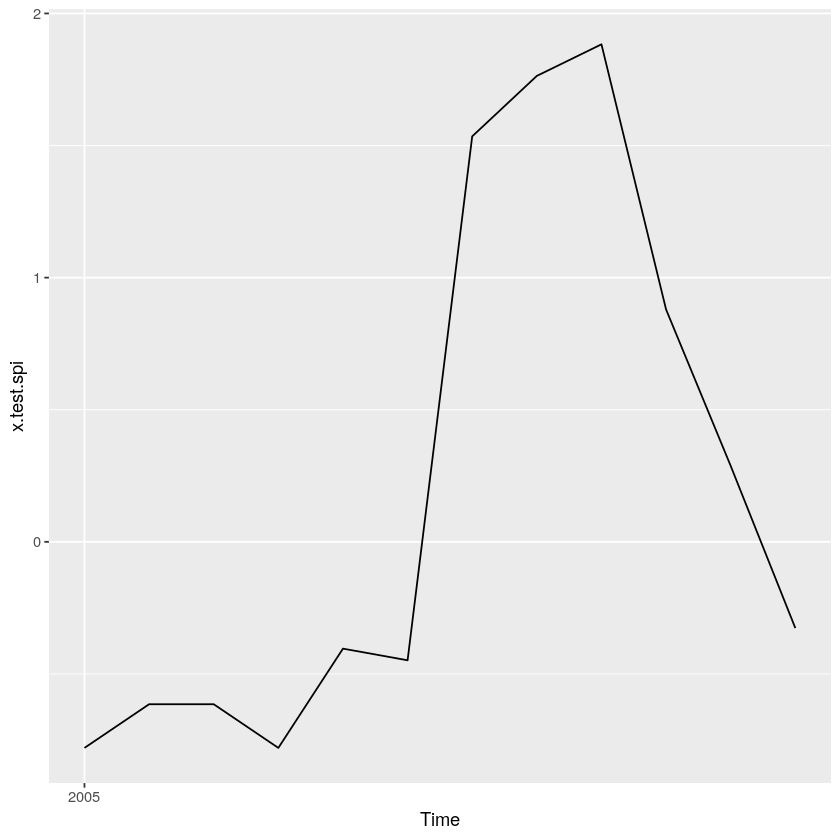

In [281]:
autoplot(x.test.spi)`

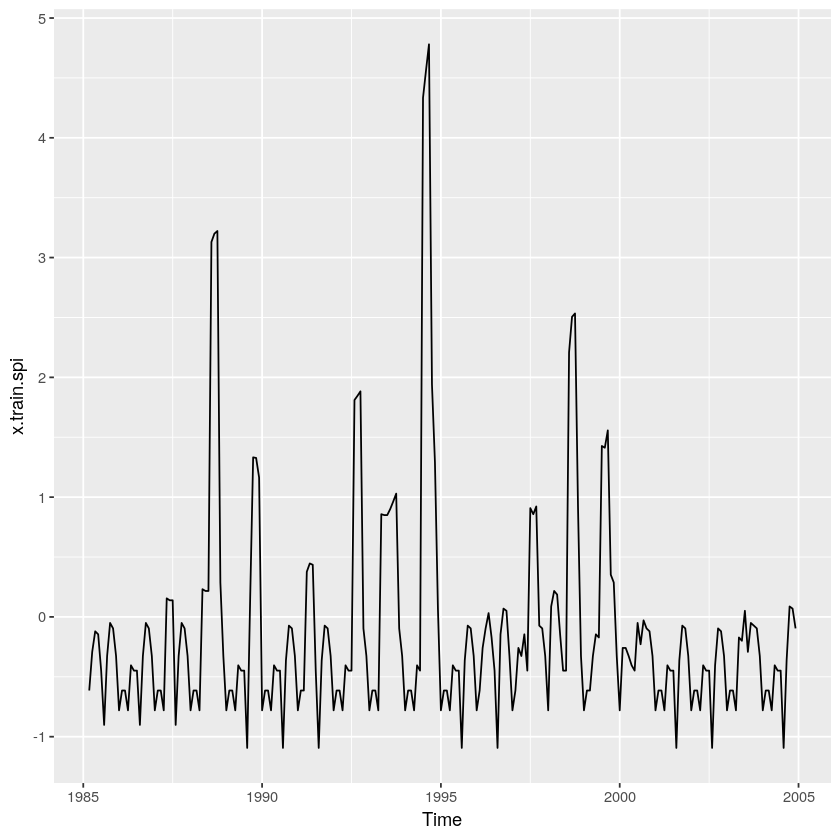

In [269]:
autoplot(x.train.spi)

In [270]:
fit = auto.arima(x.train.spi)

In [271]:
fit

Series: x.train.spi 
ARIMA(1,0,2)(0,0,1)[12] with zero mean 

Coefficients:
         ar1     ma1     ma2    sma1
      0.2204  0.6647  0.5709  0.1252
s.e.  0.1036  0.0887  0.0712  0.0602

sigma^2 estimated as 0.3393:  log likelihood=-207.82
AIC=425.65   AICc=425.91   BIC=443.01

In [272]:
A = forecast(fit,h=h)$mean
accuracy(A, x.test.spi)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,0.145752,1.047271,0.736293,97.39091,97.39091,0.6628643,0.9357905


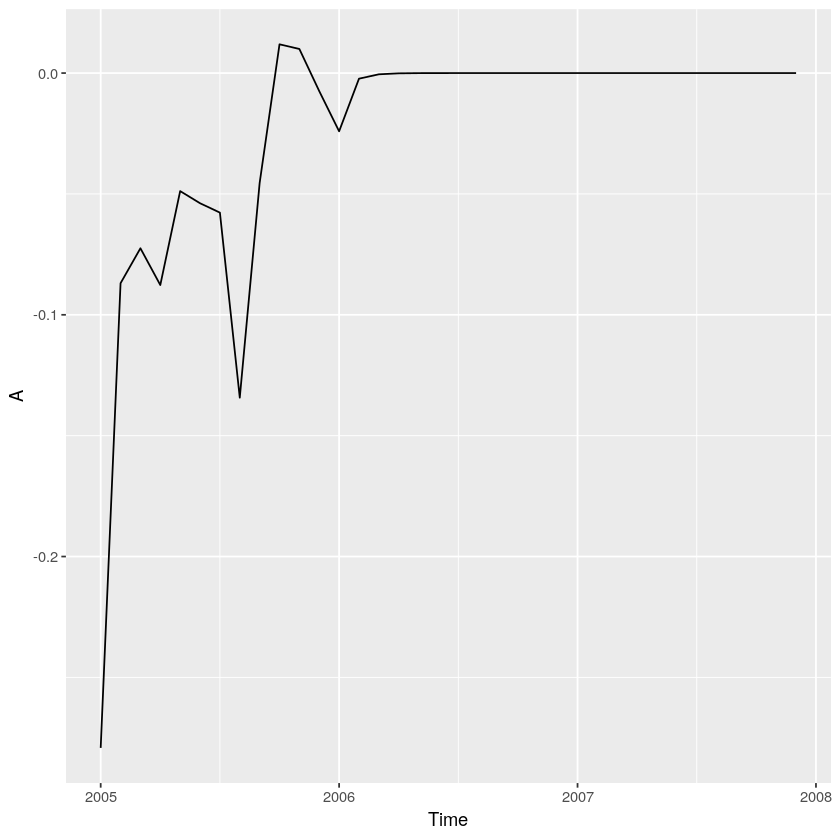

In [273]:
autoplot(A)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


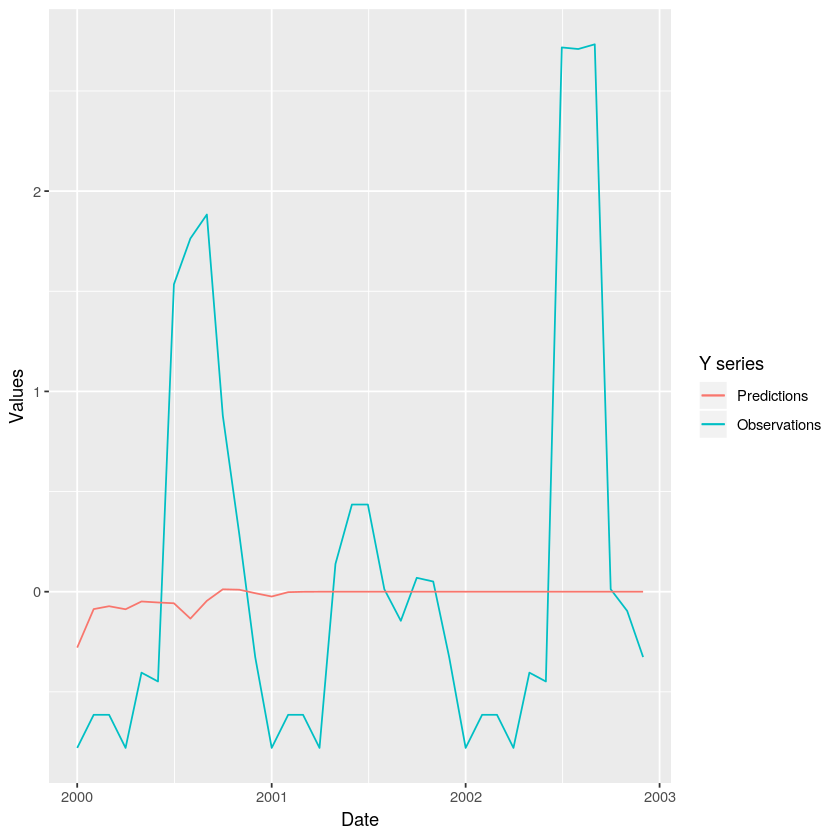

In [274]:
data <- data.frame(
  date = seq(as.Date("2000/1/1"), by = "month", length.out = length(x.test.spi)),
  x.test.spi,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test.spi,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [286]:
pa = phase_average(x.train.spi, 12)
x.train.t <- ts(pa$result, start = c(origin, start_month + n_months -1), freq=f)

APA = forecast(ets(x.train.t),h=h)$mean
APA = inv_phase_average(APA, f, pa$averages, pa$stds)

In [287]:
accuracy(APA, x.test.spi)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,0.1194194,0.8451896,0.7410042,108.9502,118.0656,0.7141659,0.7767437


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


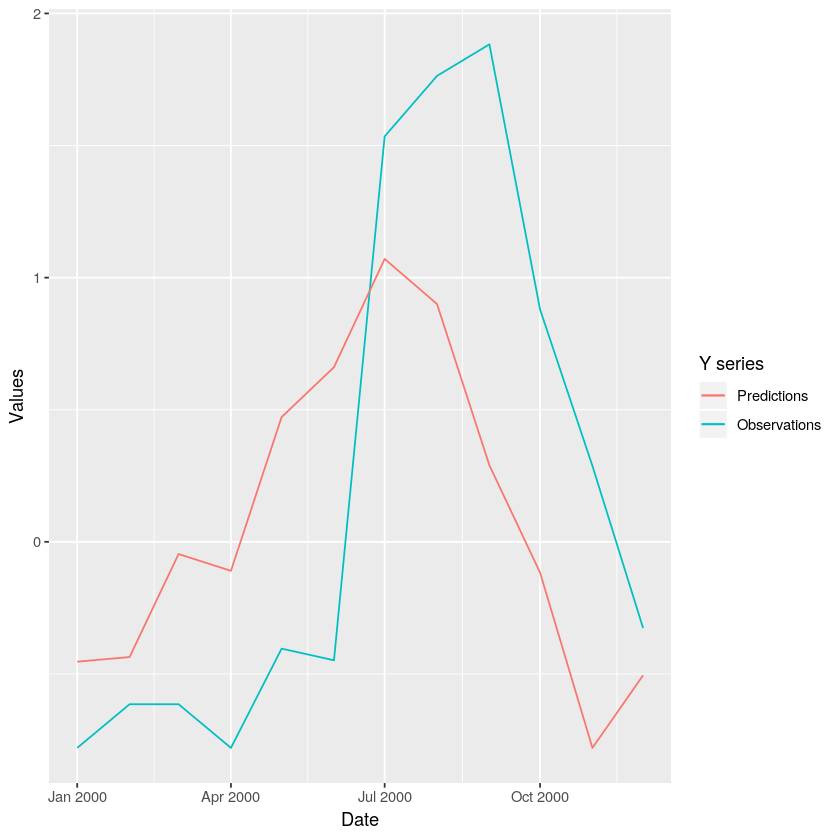

In [288]:
data <- data.frame(
  date = seq(as.Date("2000/1/1"), by = "month", length.out = length(x.test.spi)),
  x.test.spi,
  APA
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test.spi,colour="red") ) +  # first layer
  geom_line(aes(y=APA,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [290]:
ES = forecast(stl(x.train.spi,s.window="periodic", robust = TRUE), h=h, biasadj=FALSE)$mean

In [291]:
accuracy(ES, x.test.spi)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,0.471422,1.116285,0.7403005,68.21836,68.21836,0.6662483,0.9144848


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


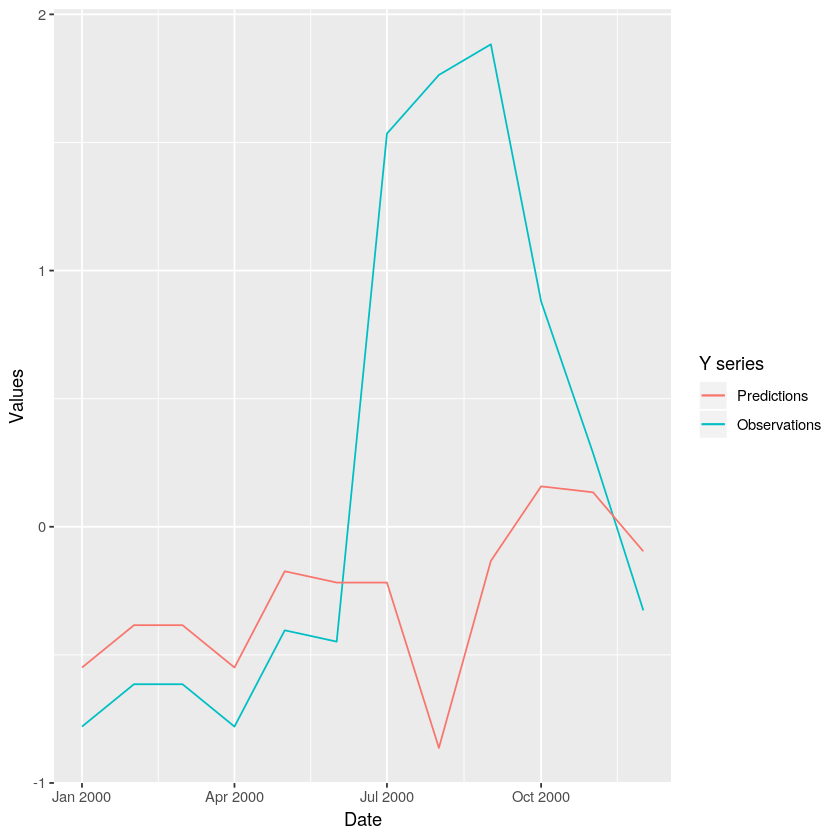

In [292]:
data <- data.frame(
  date = seq(as.Date("2000/1/1"), by = "month", length.out = length(x.test.spi)),
  x.test.spi,
  ES
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test.spi,colour="red") ) +  # first layer
  geom_line(aes(y=ES,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [243]:
mfs <- eemd(x.train.spi, num_siftings = 10, ensemble_size = 50, threads = 1)

In [244]:
n = dim(mfs)[2]
result = matrix(0.0,n,h)
for(i in c(1:n)){
    #lambda <- BoxCox.lambda(mfs[,i])
    result[i,] = forecast(auto.arima(mfs[,i], biasadj = TRUE),h, biasadj = TRUE)$mean      
}

In [215]:
y<-rowSums(mfs)
data <- data.frame(
  date = seq(as.Date("1982/1/1"), by = "month", length.out = length(x.train)),
  x.train,
  y
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.train,colour="red") ) +  # first layer
  geom_line(aes(y=y,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Observations", "MFS"))

ERROR: Error in data.frame(date = seq(as.Date("1982/1/1"), by = "month", length.out = length(x.train)), : arguments imply differing number of rows: 240, 229


In [245]:
A = colSums(result)

In [246]:
accuracy(A, x.test.spi)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,0.5848082,1.51896,1.293886,128.2778,166.226,0.796909,1.280208


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


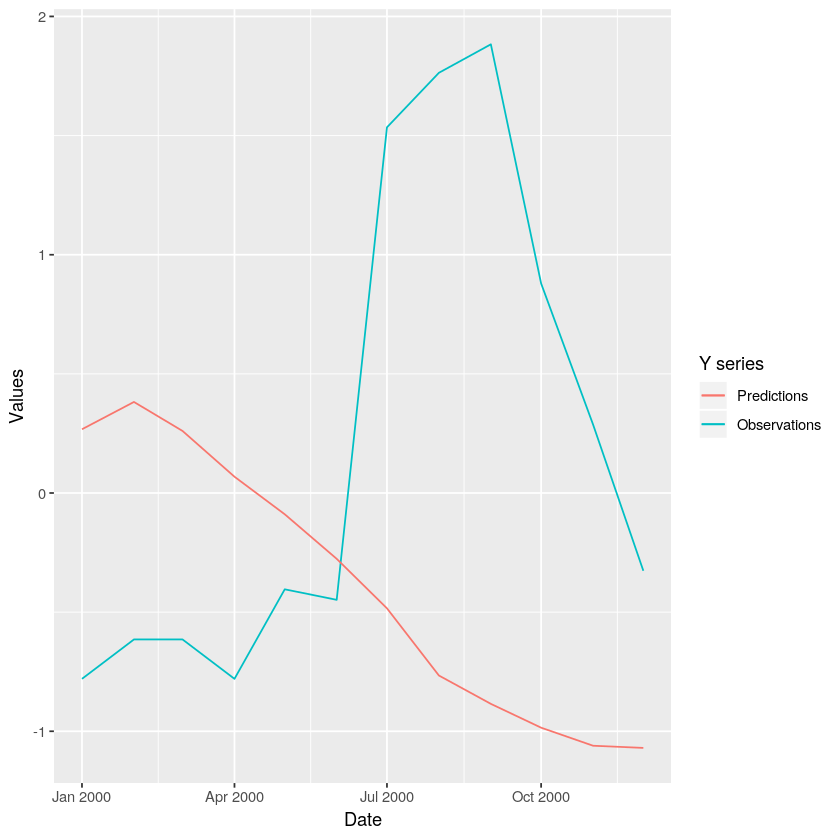

In [247]:
data <- data.frame(
  date = seq(as.Date("2000/1/1"), by = "month", length.out = length(x.test.spi)),
  x.test.spi,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test.spi,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


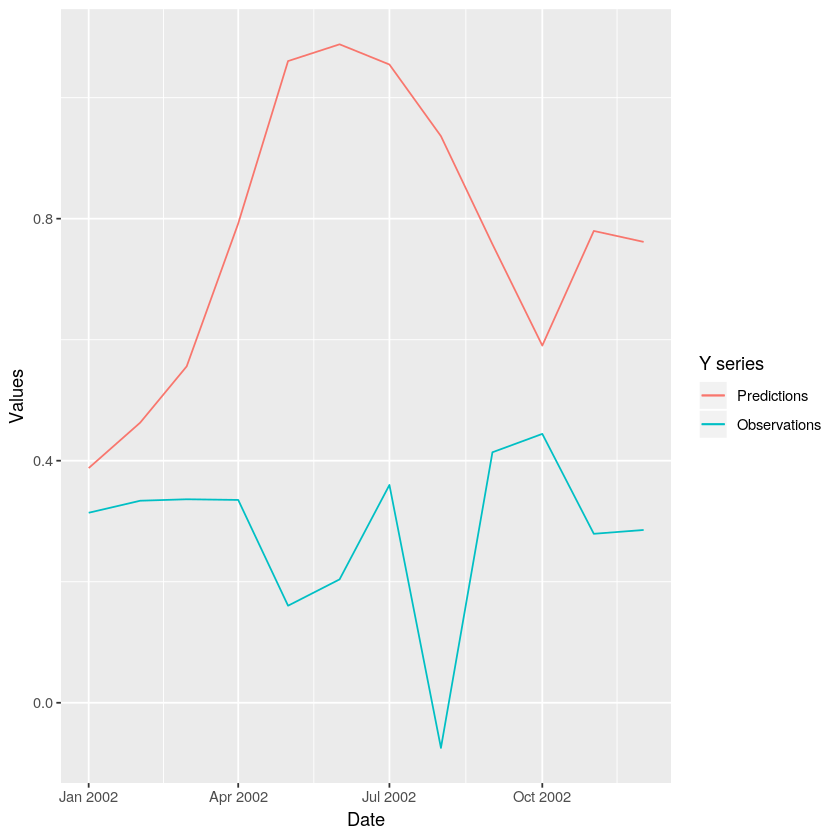

In [93]:
data <- data.frame(
  date = seq(as.Date("2002/1/1"), by = "month", length.out = m*f),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

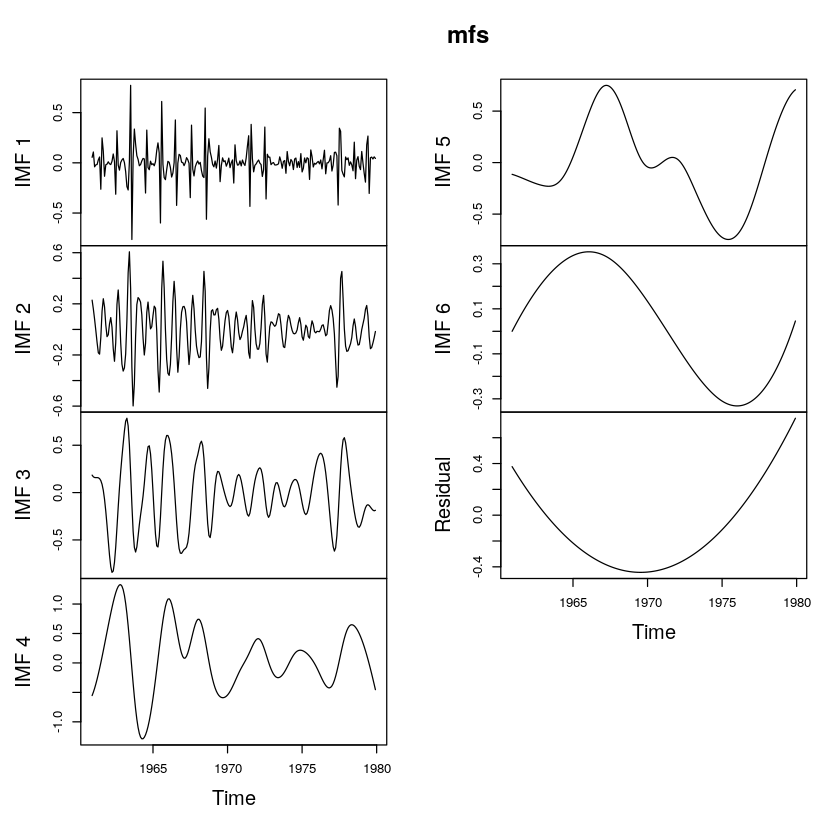

In [214]:
plot(mfs)

In [147]:
nc <- nc_open("spi3_6_12_1deg_cru_ts_3_21_1949_2012.nc")

lat <- ncvar_get(nc,"lat",verbose=F)
lon <- ncvar_get(nc,"lon",verbose=F)

time <- ncvar_get(nc,"time",verbose=F)



spi12 <- ncvar_get(nc, attributes(nc$var)$names[3])


x<-spi12[202,100,]

In [146]:
spi12[202,100,dim(spi12)[3]]

[1] 1.06547

In [148]:
#x<-x[22,8,2:dim(x)[3]]  #cluster==2
#x<-x[28,7,3:dim(x)[3]]   #cluster==0
#x<-df_cluster[["X1"]]
#x.ts<-ts(x, start = c(194, 12), freq=f)

#x <- fuzzify(x)

n=20
# Set forecasting window length (in years)
m=1
# Set start year
start = 1946
start_month = 1
origin = 1983
# Set annual sampling rate
f = 12
h = m*f
n_months = 3
h.spi = h - n_months + 1
index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start <- index
train_end <- train_start+n*f-1

test_start <- train_end + 1
test_end <- test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]
#reg.train<-df[train_start:train_end,]
#reg.test<-df[test_start:test_end,]

x.ts = ts(x, start=c(origin, start_month), freq=f)

x.train <- ts(x.train, start = c(origin, start_month), freq=f)
#reg.train <- ts(reg.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, start_month), freq=f)
#reg.test <- ts(reg.test, start = c(origin+n, 1), freq=f)

lambda <- BoxCox.lambda(x.train)

In [149]:
A = forecast(auto.arima(x.train),h=h,biasadj=TRUE)$mean


accuracy(A, x.test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-0.07230209,0.2140771,0.1699127,230.7026,247.7251,0.0550012,0.5475492


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


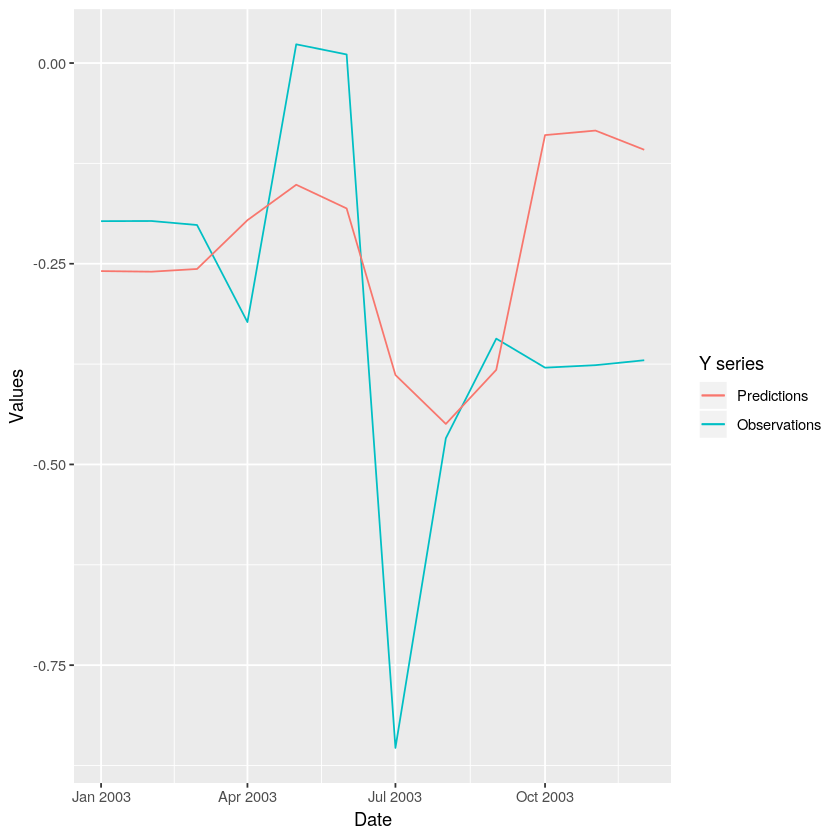

In [150]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = length(x.test)),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

In [151]:
mfs <- eemd(x.train, num_siftings = 10, ensemble_size = 50, threads = 1)

In [152]:
n = dim(mfs)[2]
result = matrix(0.0,n,h)
for(i in c(1:n)){
    #lambda <- BoxCox.lambda(mfs[,i])
    result[i,] = forecast(auto.arima(mfs[,i], biasadj = TRUE),h, biasadj = TRUE)$mean      
}

In [153]:
A = colSums(result)

accuracy(A, x.test.spi)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,0.6909893,1.835872,1.274157,87.61042,87.61042,0.4999374,1.015711


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


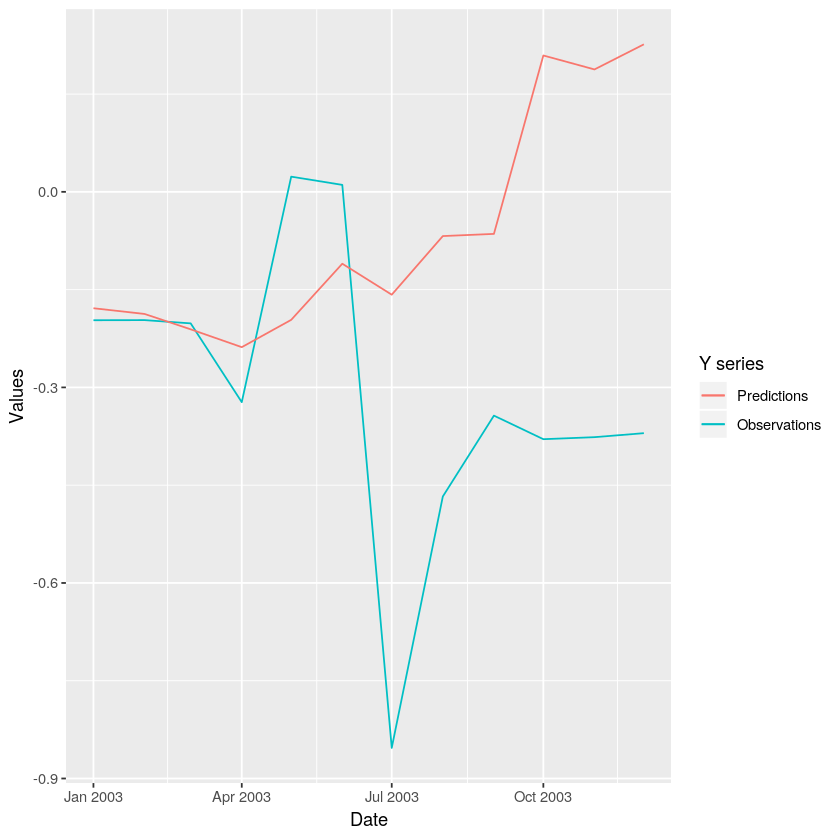

In [154]:
data <- data.frame(
  date = seq(as.Date("2003/1/1"), by = "month", length.out = length(x.test)),
  x.test,
  A
)

ggplot(data, aes(x=date)) +                    # basic graphical object
  geom_line(aes(y=x.test,colour="red") ) +  # first layer
  geom_line(aes(y=A,colour="blue"))+ ylab("Values")+ xlab("Date")+
  scale_color_discrete(name = "Y series", labels = c("Predictions", "Observations"))

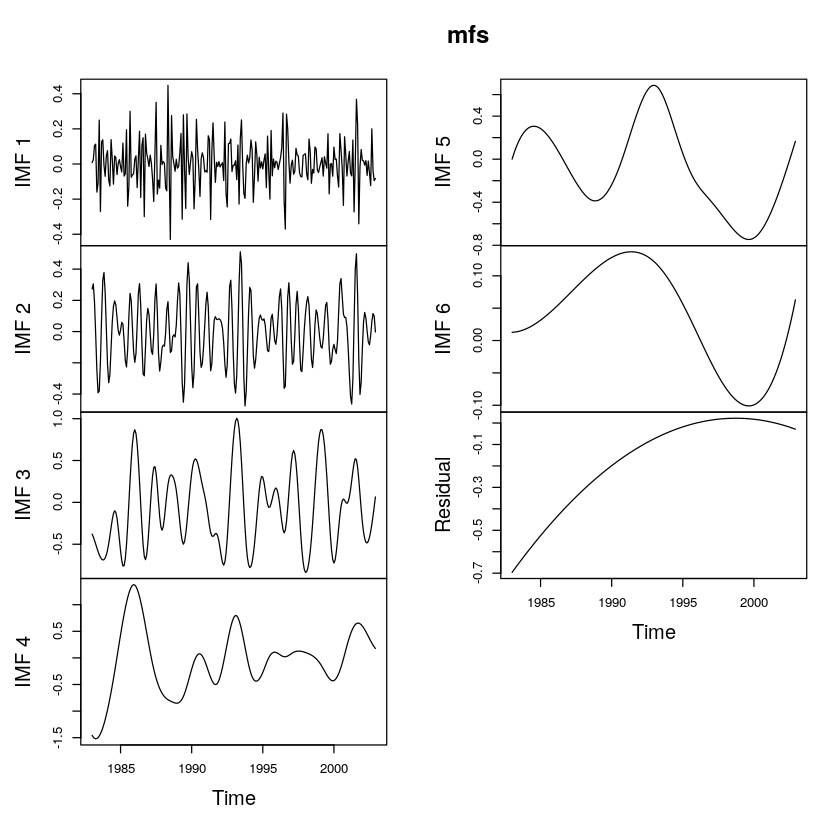

In [145]:
plot(mfs)